In [6]:
import sys
sys.path.append('../')
import joblib
from helper_files.etv_model import ETVModel
import joblib
import pandas as pd
from helper_files.plotting_functions import get_opponent_df, generate_fv_grid, plot_heatmap, generate_cp_grid
from tqdm import tqdm
tqdm.pandas()
import numpy as np
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [7]:
models = joblib.load('../data/models/xgb_models.jblb')
data_path = '../data/processed/data_1003.jblb'
DATA = joblib.load(data_path)['df']
grouped = DATA.groupby(['thrower', 'year']).size().reset_index(name='count')
valid_groups = grouped[grouped['count'] >= 50]
DATA = DATA.merge(valid_groups[['thrower', 'year']], on=['thrower', 'year'], how='inner')
DATA['etv'] = models['etv_model'].predict(DATA[models['cp_features']])
def calculate_etv_decision(row):
    defaults = {k: row[k] for k in ['possession_num', 'possession_throw', 'game_quarter', 'quarter_point', 'score_diff', 'times']}
    cp_grid = generate_cp_grid(thrower_x=row.thrower_x, thrower_y=row.thrower_y, default_columns=defaults, num_x = 50, num_y = 120)[models['cp_features']]
    all_etv = models['etv_model'].predict(cp_grid)
    return row.etv / max(all_etv)
DATA['etv_decision'] = DATA.progress_apply(calculate_etv_decision, axis=1)
# DATA.to_csv('../data/etv_decision_data.csv', index=False)

100%|██████████| 260218/260218 [1:24:08<00:00, 51.54it/s]  


In [57]:
DATA = pd.read_csv('../data/etv_decision_data.csv')

In [65]:
grouped = DATA.groupby(['thrower']).year.nunique().reset_index(name='count')
valid_groups = grouped[grouped['count'] >= 3]
DATA = DATA.merge(valid_groups[['thrower']], on=['thrower'], how='inner')

In [67]:
def get_opponent_data(df, features):
    opponent_data = df[features].copy()
    opponent_data['thrower_x'] = opponent_data.receiver_x * -1
    opponent_data.loc[:, 'thrower_y'] = (120 - opponent_data.loc[:, 'receiver_y']).clip(lower=20, upper=100)
    opponent_data.loc[:, 'possession_num'] += 1
    if 'possession_num' in opponent_data.columns:
        opponent_data.loc[:, 'possession_num'] += 1

    if 'possession_throw' in opponent_data.columns:
        opponent_data.loc[:, 'possession_throw'] = 1

    if 'score_diff' in opponent_data.columns:
        opponent_data.loc[:, 'score_diff'] = -opponent_data.loc[:, 'score_diff']
    opponent_data = opponent_data.drop(['receiver_x', 'receiver_y'], axis=1)
    return opponent_data

fv_scaler = models['etv_model'].fv_scaler
thrower_fv_features = models['fv_model']['features']
receiver_fv_features = [x.replace('thrower', 'receiver') for x in models['fv_model']['features']]
DATA['thrower_fv'] = models['fv_model']['model'].predict_proba(fv_scaler.transform(DATA[thrower_fv_features]))[:,1]
DATA['receiver_fv'] = models['fv_model']['model'].predict_proba(fv_scaler.transform(DATA[receiver_fv_features].values))[:,1]
DATA.loc[DATA.receiver_y > 100, 'receiver_fv'] = 1
opponent_data = get_opponent_data(DATA, receiver_fv_features)
DATA['opponent_fv'] = models['fv_model']['model'].predict_proba(fv_scaler.transform(opponent_data.values))[:,1]
DATA['ec'] = DATA['opponent_fv'] - DATA['thrower_fv']  
DATA.loc[DATA['completion'] == 1, 'ec'] = DATA['receiver_fv'] - DATA['thrower_fv']


/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [68]:
def pivot_metric_columns(df, metrics):
    """Pivot metrics columns into a long format."""
    return df.melt(
        id_vars=['player', 'year'], 
        value_vars=metrics,
        var_name='metric',
        value_name='value'
    )

def calculate_discrimination(bv, sv):
    """Calculate discrimination metric from bootstrapped and seasonal variance."""
    discrimination = (
        bv
        .merge(sv, on=['year', 'metric'], suffixes=('_bv', '_sv'))  # Inner join on year and metric
        .assign(discrimination=lambda x: 1 - x['bv'] / x['sv'])  # Calculate discrimination
        .sort_values(by=['year', 'metric'])  # Sort by year and metric
    )
    
    return discrimination[['year', 'metric', 'discrimination']]

def calculate_within_player_variance(player_game_season_stats, metrics):
    """Calculate within-player variance based on the player game season stats dataframe."""
    # Pivoting metrics for calculation
    pivoted_stats = (
        player_game_season_stats
        .melt(id_vars=['player', 'year'], 
              value_vars=metrics,
              var_name='metric', value_name='value')
    )

    within_player_variance = (
        pivoted_stats
        .groupby(['player', 'metric'], as_index=False)  # Group by player and metric
        .agg(
            seasons_played=('value', 'count'),  # Count of seasons played
            wv=('value', lambda x: x.var(ddof=0))  # Calculate variance
        )
    )

    # Filter for players with a minimum of 3 seasons played and calculate mean wv
    wv = (
        within_player_variance[within_player_variance['seasons_played'] >= 3]
        .groupby('metric', as_index=False)
        .agg(wv=('wv', 'mean'))  # Mean within-player variance
        .sort_values('metric')
    )
    
    return wv

def calculate_total_variance(player_game_season_stats, metrics):
    """Calculate total variance for each metric."""
    # Pivoting metrics for calculation
    pivoted_stats = (
        player_game_season_stats
        .melt(id_vars=['player', 'year'], 
              value_vars=metrics,
              var_name='metric', value_name='value')
    )

    # Calculate total variance for each metric
    tv = (
        pivoted_stats
        .groupby('metric', as_index=False)
        .agg(tv=('value', lambda x: x.var(ddof=0)))  # Total variance
        .sort_values('metric')
    )

    return tv

def calculate_stability(bv, tv, wv):
    """Calculate stability based on average bootstrap variance, total variance, and within-player variance."""
    
    # Calculate average bootstrap variance
    average_bv = bv.groupby('metric', as_index=False).agg(bv=('bv', 'mean')).reset_index()
    
    # Merge dataframes for stability calculation
    stability = (
        average_bv
        .merge(tv, on='metric', how='inner')
        .merge(wv, on='metric', how='inner')
        .assign(stability=lambda x: 1 - (x['wv'] - x['bv']) / (x['tv'] - x['bv']))
        .sort_values('metric')
    )

    return stability

In [69]:
def calculate_metric(data, group_keys, agg_func, new_name, col_to_extract=None):
    if col_to_extract is not None:
        return data.groupby(group_keys)[col_to_extract].agg(agg_func).reset_index(name=new_name)
    return data.groupby(group_keys).agg(agg_func).reset_index(name=new_name)

def calculate_goals(data):
    return calculate_metric(data[(data['receiver_y'] > 100) & (data['completion'])], ['receiver', 'year', 'gameID'], 'size', 'goals')

def calculate_assists(data):
    return calculate_metric(data[(data['completion']) & (data['receiver_y'] > 100)], ['thrower', 'year', 'gameID'], 'size', 'assists')

def calculate_completion_percentage(data):
    throws = calculate_metric(data, ['thrower', 'year', 'gameID'], 'size', 'total_throws')
    completions = calculate_metric(data[data['completion'] == 1], ['thrower', 'year', 'gameID'], 'size', 'completed_throws')
    completion = throws.merge(completions, on=['thrower', 'year', 'gameID'], how='left').fillna(0)
    completion['completion_percentage'] = completion['completed_throws'] / completion['total_throws'] * 100
    return completion[['thrower', 'year', 'gameID', 'completion_percentage']]

def calculate_yards(data, group_key, yard_col):
    successful_throws = data[data['completion'] == 1]
    successful_throws[yard_col] = successful_throws['receiver_y'].clip(0, 100) - successful_throws['thrower_y']
    return calculate_metric(successful_throws, group_key, 'sum', yard_col, yard_col)

def create_stats(data, per_possession_stats):
    metrics = {
        'goals': calculate_goals(data).rename(columns={'receiver': 'player'}),
        'assists': calculate_assists(data).rename(columns={'thrower': 'player'}),
        'completion_percentage': calculate_completion_percentage(data).rename(columns={'thrower': 'player'}),
        'offensive_possessions': calculate_metric(data.drop_duplicates(['thrower', 'year', 'gameID', 'home_team_score', 'away_team_score', 'possession_num', 'game_quarter']),
                                                   ['thrower', 'year', 'gameID'], 'size', 'offensive_possessions').rename(columns={'thrower': 'player'}),
        'completions': calculate_metric(data[data['completion'] == 1], ['thrower', 'year', 'gameID'], 'size', 'completions').rename(columns={'thrower': 'player'}),
        'throwing_yards': calculate_yards(data, ['thrower', 'year', 'gameID'], 'throwing_yards').rename(columns={'thrower': 'player'}),
        'receiving_yards': calculate_yards(data, ['receiver', 'year', 'gameID'], 'receiving_yards').rename(columns={'receiver': 'player'}),
        'etv_decision': calculate_metric(data, ['thrower', 'year', 'gameID'], 'mean', 'etv_decision', 'etv_decision').rename(columns={'thrower': 'player'}),
        'etv_sum': calculate_metric(data, ['thrower', 'year', 'gameID'], 'sum', 'etv_sum', 'etv').rename(columns={'thrower': 'player'}),
        'etv_mean': calculate_metric(data, ['thrower', 'year', 'gameID'], 'mean', 'etv_mean', 'etv').rename(columns={'thrower': 'player'}),
        'thrower_ec': calculate_metric(data, ['thrower', 'year', 'gameID'], 'sum', 'thrower_ec', 'ec').rename(columns={'thrower': 'player'}),
        'receiver_ec': calculate_metric(data, ['receiver', 'year', 'gameID'], 'sum', 'receiver_ec', 'ec').rename(columns={'receiver': 'player'}),
        'hockey_assists': calculate_metric(data[data['hockey_assist'] == 1], ['thrower', 'year', 'gameID'], 'sum', 'hockey_assists', 'hockey_assist').rename(columns={'thrower': 'player'}),
        'games_played': calculate_metric(data, ['thrower', 'year', 'gameID'], 'count', 'games_played', 'gameID').rename(columns={'thrower': 'player'}),
        'offensive_team_goals': calculate_metric(data.drop_duplicates(['thrower', 'year', 'gameID', 'home_team_score', 'away_team_score', 'possession_num', 'game_quarter']),
                                                   ['thrower', 'year', 'gameID'], 'sum', 'offensive_team_goals', 'point_outcome').rename(columns={'thrower': 'player'}),
    }
    season_stats = None
    for metric_name, metric_df in metrics.items():
        if season_stats is None:
            season_stats = metric_df
        else:
            season_stats = pd.merge(season_stats, metric_df, on=['player', 'year', 'gameID'], how='outer')

    season_stats['total_yards'] = season_stats['throwing_yards'].fillna(0) + season_stats['receiving_yards'].fillna(0)
    season_stats['total_scores'] = season_stats['goals'].fillna(0) + season_stats['assists'].fillna(0)
    season_stats['total_ec'] = season_stats['thrower_ec'].fillna(0) + season_stats['receiver_ec'].fillna(0)
    season_stats['offensive_efficiency'] = season_stats['offensive_team_goals'].fillna(0) / season_stats['offensive_possessions']
    season_stats = season_stats.drop(['offensive_team_goals'], axis=1)

    season_stats[['goals', 'assists', 'offensive_possessions', 'completions']] = season_stats[
        ['goals', 'assists', 'offensive_possessions', 'completions']].fillna(0)
    for stat in per_possession_stats:
        if stat not in ['games_played', 'offensive_possessions'] and stat not in ['player', 'year', 'gameID']:
            season_stats[f'{stat}_per_possession'] = season_stats[stat] / season_stats['offensive_possessions'].replace(0, np.nan)

    return season_stats


In [71]:
per_possession_stats = ['goals', 'assists', 'hockey_assists', 'thrower_ec', 'receiver_ec', 'throwing_yards', 'etv_sum']
metrics=['goals', 'assists', 'completion_percentage', 'thrower_ec', 'receiver_ec', 'total_ec',
                          'offensive_possessions', 'completions', 'games_played', 'offensive_efficiency',
                          'throwing_yards', 'receiving_yards', 'total_yards', 'etv_decision', 'etv_sum', 'etv_mean', 'hockey_assists']
metrics_with_per_possession =  metrics + [x + '_per_possession' for x in per_possession_stats]
# Run the function on your dataframe DATA
player_game_season_stats = create_stats(DATA, per_possession_stats)
player_game_season_stats = player_game_season_stats[player_game_season_stats.groupby(['player', 'year'])['completions'].transform('sum') >= 10].reset_index(drop=True)

resampled_player_season_variance = (pivot_metric_columns(player_game_season_stats, metrics_with_per_possession).groupby(['year', 'player', 'metric']).agg(bv=('value', lambda x: x.var(ddof=0))) )
bv = (resampled_player_season_variance.groupby(['year', 'metric']).agg(bv=('bv', 'mean')).reset_index())
pivoted_player_season_stats = pivot_metric_columns(player_game_season_stats, metrics_with_per_possession)
sv = (pivoted_player_season_stats.groupby(['year', 'metric']).agg(sv=('value', lambda x: x.var(ddof=0))).reset_index().sort_values(by=['year', 'metric']))
discrimination_stats = calculate_discrimination(bv, sv)
wv_stats = calculate_within_player_variance(player_game_season_stats, metrics_with_per_possession)
tv_stats = calculate_total_variance(player_game_season_stats, metrics_with_per_possession)
stability_stats = calculate_stability(bv, tv_stats, wv_stats)


/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_5001/2634245355.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_throws[yard_col] = successful_throws['receiver_y'].clip(0, 100) - successful_throws['thrower_y']
/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_5001/2634245355.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_throws[yard_col] = successful_throws['receiver_y'].clip(0, 100) - successful_throws['thrower_y']


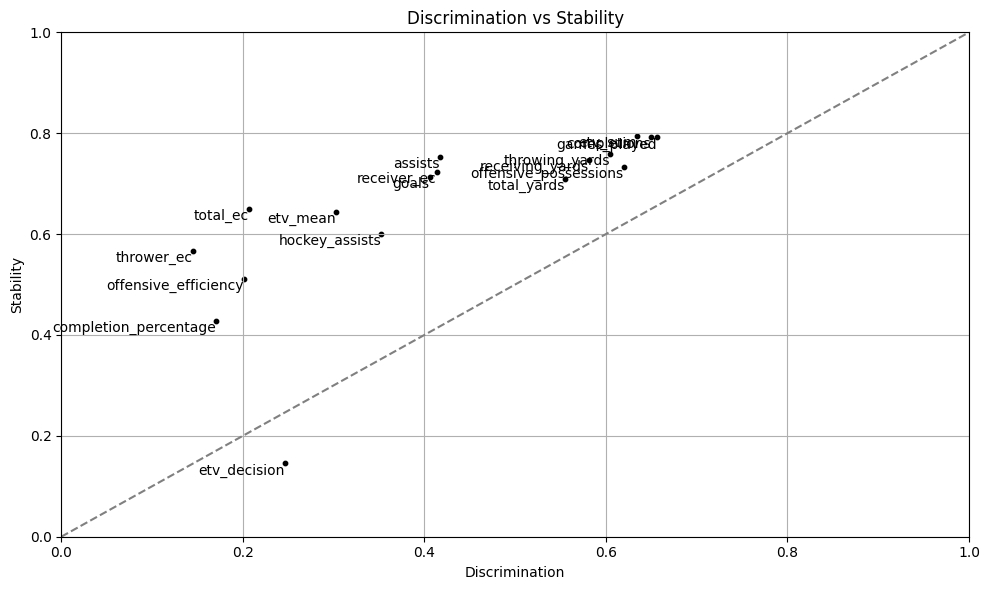

In [72]:
# Assuming `discrimination` and `stability` dataframes are defined and contain the metric column
# Merging dataframes on 'metric'
merged_df = pd.merge(discrimination_stats[discrimination_stats.metric.isin(metrics)].groupby(['metric']).mean()['discrimination'], stability_stats, on='metric')

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['discrimination'], merged_df['stability'], color='black', s=10)

# Adding text annotations for each point
for i, row in merged_df.iterrows():
    plt.text(row['discrimination'], row['stability'], row['metric'], fontsize=10, ha='right', va='top', rotation=0)

plt.title('Discrimination vs Stability')
plt.xlabel('Discrimination')
plt.ylabel('Stability')

# Set x and y limits to [0, 1]
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add dotted line for x=y
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.grid()
plt.tight_layout()
plt.show()


In [73]:
merged_df[['metric', 'discrimination', 'stability']].sort_values('stability')

,metric,discrimination,stability
3,etv_decision,0.246195,0.145180
1,completion_percentage,0.170305,0.427022
9,offensive_efficiency,0.201474,0.511946
13,thrower_ec,0.145141,0.567147
8,hockey_assists,0.352337,0.599948
4,etv_mean,0.302463,0.643824
15,total_ec,0.206862,0.650135
16,total_yards,0.555424,0.710023
7,goals,0.405734,0.712268
11,receiver_ec,0.413470,0.723855


In [92]:
DATA.etv_decision.describe()

count    154706.000000
mean          0.861901
std           0.208254
min          -0.948574
25%           0.837190
50%           0.911196
75%           0.950204
max          26.936827
Name: etv_decision, dtype: float64

In [89]:
# Extracting relevant metrics
independence_metrics = ['goals',
 'assists',
 'etv_mean',
 'hockey_assists',
 'offensive_efficiency']
metrics_data = player_game_season_stats[independence_metrics].dropna()

# Step 1: Compute the correlation matrix
correlation_matrix = metrics_data.corr()

# Step 2: Calculate R-squared for independence scores
independence_scores = {}
for metric in independence_metrics:
    # Exclude the current metric for regression
    other_metrics = metrics_data.drop(columns=[metric])
    
    # Fit OLS regression
    model = sm.OLS(metrics_data[metric], other_metrics).fit()
    
    # Calculate R-squared
    r_squared = model.rsquared
    independence_scores[metric] = 1 - r_squared  # I_m^M

# Step 3: Run PCA
pca = PCA()
pca.fit(correlation_matrix)

total_variance = metrics_data.var().sum()

# Calculate each metric's contribution to total variance
explained_variance = metrics_data.var() / total_variance

# Create DataFrame for results
independence_df = pd.DataFrame({
    'metric': independence_scores.keys(),
    'independence_score': independence_scores.values(),
    'explained_variance': explained_variance[:len(independence_scores)]
})

independence_df.sort_values('independence_score', ascending=False)


,metric,independence_score,explained_variance
goals,goals,0.604929,0.263026
assists,assists,0.452043,0.479632
hockey_assists,hockey_assists,0.260368,0.252484
offensive_efficiency,offensive_efficiency,0.039800,0.004348
etv_mean,etv_mean,0.039272,0.000510


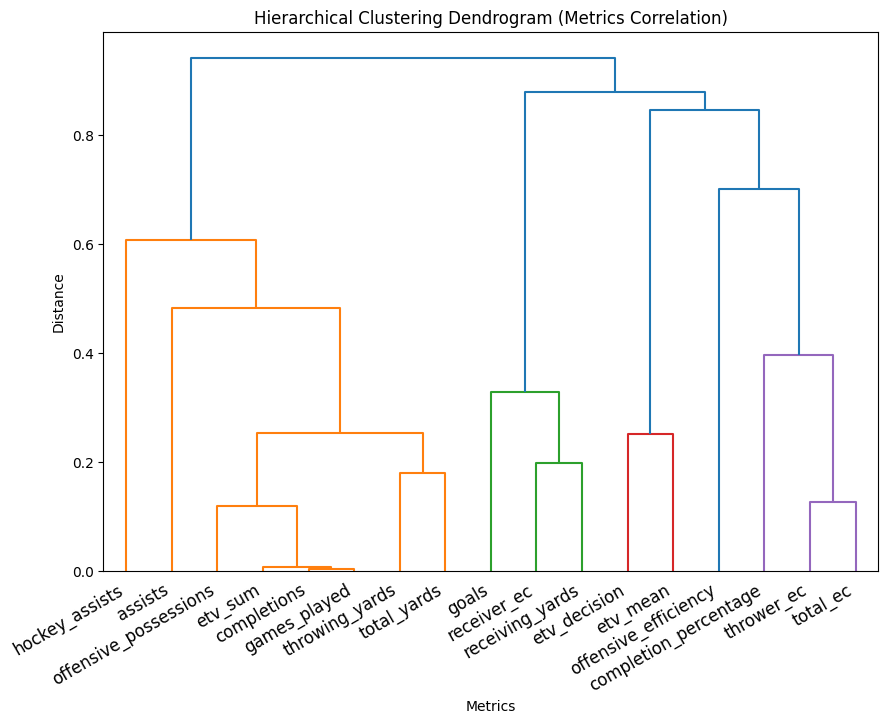

In [75]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Assuming you have already calculated the correlation matrix
metrics_data = player_game_season_stats[independence_metrics].dropna()
correlation_matrix = metrics_data.corr()

# Step 2: Convert the correlation matrix to a distance matrix
# Distance = 1 - correlation
distance_matrix = 1 - correlation_matrix

# Step 3: Perform hierarchical clustering
# Use 'average', 'single', 'complete', or other linkage methods as appropriate
Z = sch.linkage(sch.distance.squareform(distance_matrix), method='average')

# Step 4: Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z, labels=correlation_matrix.columns)
plt.title('Hierarchical Clustering Dendrogram (Metrics Correlation)')
plt.xlabel('Metrics')
plt.ylabel('Distance')
plt.xticks(rotation=30, ha='right')
plt.show()


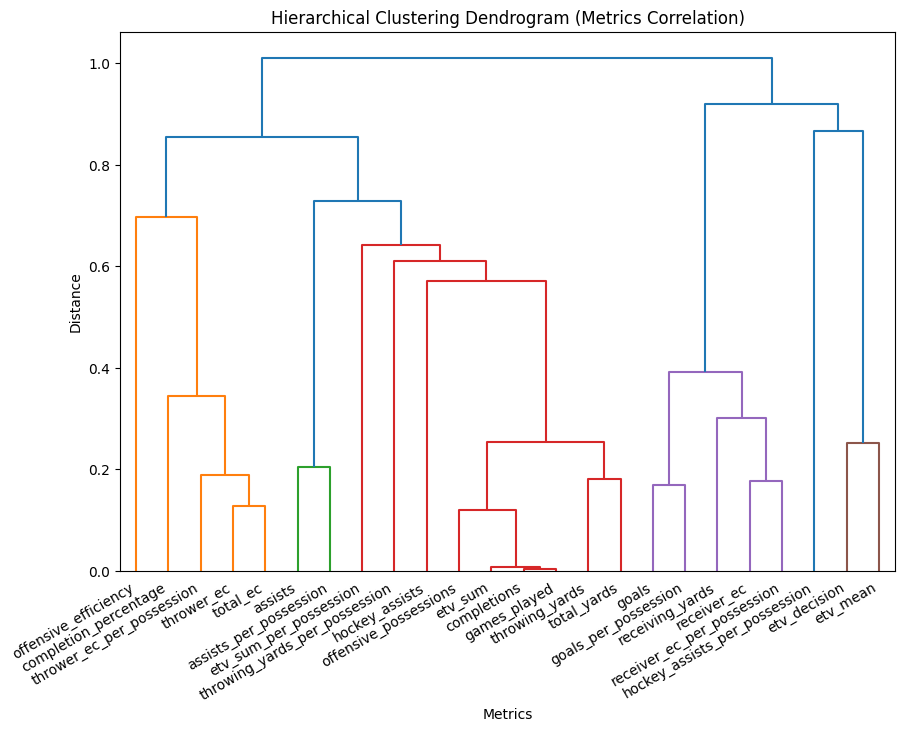

In [76]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Assuming you have already calculated the correlation matrix
metrics_data = player_game_season_stats[metrics_with_per_possession].dropna()
correlation_matrix = metrics_data.corr()

# Step 2: Convert the correlation matrix to a distance matrix
# Distance = 1 - correlation
distance_matrix = 1 - correlation_matrix

# Step 3: Perform hierarchical clustering
# Use 'average', 'single', 'complete', or other linkage methods as appropriate
Z = sch.linkage(sch.distance.squareform(distance_matrix), method='average')

# Step 4: Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z, labels=correlation_matrix.columns)
plt.title('Hierarchical Clustering Dendrogram (Metrics Correlation)')
plt.xlabel('Metrics')
plt.ylabel('Distance')
plt.xticks(rotation=30, ha='right')
plt.show()
